# **Pattern Recognition Course (Fall 2024) - Assignment #4**

**Due date**: 10th of Bahman 1403

**Objective**: 
-   Design a SVM  classifier with RBF, linear, and polynomial kernels to predict customer's age bucket based on spending, salary, location etc. This classification could offer insights for targeted marketing.
-   Observe the effect of normalization of the result

**Dataset**: 1000 customers of a retail store in New York. 


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import UndefinedMetricWarning

import warnings
from itertools import combinations
from pprint import pprint
from prettytable import PrettyTable


# 1. Data Collection

In [2]:
df = pd.read_csv(
    "retailMarketing(Original).csv",
    sep=",",
    index_col=0,
)# ignoring first column as an index

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              1000 non-null   object
 1   Salary           1000 non-null   int64 
 2   Children         1000 non-null   int64 
 3   AmountSpent      1000 non-null   int64 
 4   Gender_Female    1000 non-null   int64 
 5   Gender_Male      1000 non-null   int64 
 6   OwnHome_Own      1000 non-null   int64 
 7   OwnHome_Rent     1000 non-null   int64 
 8   Married_Married  1000 non-null   int64 
 9   Married_Single   1000 non-null   int64 
 10  Location_Close   1000 non-null   int64 
 11  Location_Far     1000 non-null   int64 
 12  History_High     1000 non-null   int64 
 13  History_Low      1000 non-null   int64 
 14  History_Medium   1000 non-null   int64 
 15  Catalogs_6       1000 non-null   int64 
 16  Catalogs_12      1000 non-null   int64 
 17  Catalogs_18      1000 non-null   int64 

,Age,Salary,Children,AmountSpent,Gender_Female,Gender_Male,OwnHome_Own,OwnHome_Rent,Married_Married,Married_Single,Location_Close,Location_Far,History_High,History_Low,History_Medium,Catalogs_6,Catalogs_12,Catalogs_18,Catalogs_24
0,Old,47500,0,755,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0
1,Middle,63600,0,1318,0,1,0,1,0,1,1,0,0,0,1,1,0,0,0
2,Young,13500,0,296,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0
3,Middle,85600,1,2436,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0
4,Middle,68400,0,1304,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0


# Stage 2: Data Preprocessing

## 2.1 Redundancy Reduction

Multiple columns in the dataset branched off of a single field and are mutually exclusive hence exhibit redundancy.
It seems that Catalogs used to be a categorical feature and went thru one hot encoding whether the extra cardinality proves to be insightful, is yet to be investigated

In [3]:
df["Gender"] = df["Gender_Female"]  # Encode Female as 1, Male as 0
df["OwnHome"] = df["OwnHome_Own"]  # Encode OwnHome_Own as 1, rent as 0
df["Married"] = df["Married_Married"]  # Encode Married_Married as 1, single as 0
df["History"] = np.select(
    [df["History_Low"] == 1, df["History_Medium"] == 1, df["History_High"] == 1],
    [0, 1, 2],
    default=-1,  # Fallback for potential errors (e.g., all zeros)
)

df["Catalogs"] = np.select(
    [
        df["Catalogs_6"] == 1,
        df["Catalogs_12"] == 1,
        df["Catalogs_18"] == 1,
        df["Catalogs_24"] == 1,
    ],
    [6, 12, 18, 24],
    default=-1,  # Fallback for potential errors (e.g., all zeros)
)

df = df.drop(
    columns=[
        "Gender_Female",
        "Gender_Male",
        "OwnHome_Rent",
        "OwnHome_Own",
        "Married_Married",
        "Married_Single",
        "Location_Far",
        "History_Low",
        "History_Medium",
        "History_High",
        "Catalogs_6",
        "Catalogs_12",
        "Catalogs_18",
        "Catalogs_24",
    ]
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             1000 non-null   object
 1   Salary          1000 non-null   int64 
 2   Children        1000 non-null   int64 
 3   AmountSpent     1000 non-null   int64 
 4   Location_Close  1000 non-null   int64 
 5   Gender          1000 non-null   int64 
 6   OwnHome         1000 non-null   int64 
 7   Married         1000 non-null   int64 
 8   History         1000 non-null   int64 
 9   Catalogs        1000 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 85.9+ KB


,Age,Salary,Children,AmountSpent,Location_Close,Gender,OwnHome,Married,History,Catalogs
0,Old,47500,0,755,0,1,1,0,0,6
1,Middle,63600,0,1318,1,0,0,0,1,6
2,Young,13500,0,296,1,1,0,0,1,18
3,Middle,85600,1,2436,1,0,1,1,2,18
4,Middle,68400,0,1304,1,1,1,0,2,12


## 2.2 Label Encoding

In [4]:
label_encoder = LabelEncoder()
df["Age"] = label_encoder.fit_transform(df["Age"])

age_labels = ["Middle", "Old", "Young"]
label_encoder.fit(age_labels)  # Original class labels
_label_encoder_dict = dict(
    zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
)
label_encoder_dict = {int(v): str(k) for k, v in _label_encoder_dict.items()}

pprint(label_encoder_dict)

{0: 'Middle', 1: 'Old', 2: 'Young'}


## 2.3 Extract Target from Features

In [5]:
target = "Age"
x = df.drop(columns=[target])
y = df[target]


## 2.4 Create Train-Test Segments

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=0
)
print(
    f"number of training samples = {len(X_train)}\n number of test samples = {len(X_test)}"
)


number of training samples = 700
 number of test samples = 300


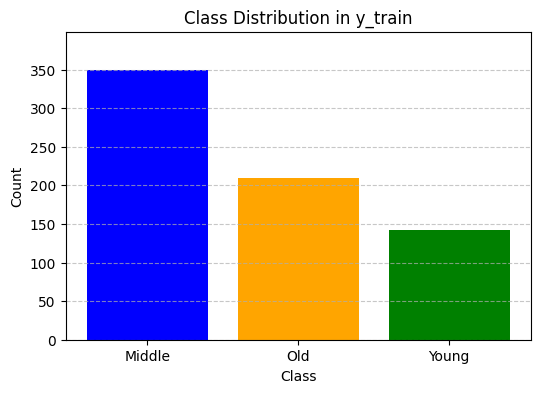

In [82]:
class_priors = y_train.value_counts().values

plt.figure(figsize=(6, 4))
plt.bar(age_labels, class_priors, color=['blue', 'orange', 'green'])

# Labels
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in y_train")
plt.ylim(0, max(class_priors) + 50) 
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show
plt.show()


## 2.5 Standardization (Z-Score Scaling):
> Distance-based methods (like SVM and KNN) will be **dominated by larger-magnitude features**, leading to poor decision boundaries.

Transforms features to have zero mean and unit standard deviation.
$$
X' = \frac{X - \mu}{\sigma}
$$

Standardization characteristics:
- Changes the shape of the distribution.
- Less sensitive to outliers compared to min-max scaling.

> Applying standardization before splitting the dataset into train and test sets is generally considered bad practice
> due to **data leakage issues** which gives the model an indirect access to test set statistics leading to optimistic performance estimates.

In [85]:
scaler = StandardScaler()
X_train[["Salary", "AmountSpent"]] = scaler.fit_transform(X_train[["Salary", "AmountSpent"]])

X_test[["Salary", "AmountSpent"]] = scaler.transform(X_test[["Salary", "AmountSpent"]])

X_test.head()

,Salary,Children,AmountSpent,Location_Close,Gender,OwnHome,Married,History,Catalogs
993,1.392458,0,4.696569,0,1,1,1,0,24
859,1.194315,1,1.582597,1,0,0,1,1,24
298,-0.668870,0,0.461829,1,1,0,0,0,18
553,0.328237,0,0.266865,1,1,1,1,2,24
672,-0.844642,0,-0.494473,1,0,0,0,2,18


# Stage 3: Training

## SVM optimization 

$$
\begin{align*}
&\text{Maximize the margin while correctly classifying points. This is formulated as:} \\\\
&\min_{w,b,\xi} \frac{1}{2}||w||^2 + C\sum_{i=1}^{N}\xi_i \\\\
&\text{Subject to:} \\\\
&y_i(\mathbf{w}^\top\phi(\mathbf{x}_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0 \quad \forall i \\\\
&\textbf{Components:} \\
&1. \frac{1}{2}||w||^2: \text{ Minimizing this ensures a large margin.} \\
&2. \sum_{i=1}^{N}\xi_i: \text{ Slack variables ($\xi_i$) allow for misclassification.} \\
&3. C: \text{ Regularization parameter balancing margin size vs. misclassification.}
\end{align*}
$$

> Skit-learn has recruits 2 strategies for utilizing an intrinsically binary classifier such as SVM for Multi Class classification. “one-versus-one” is used approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes.

In [123]:
pairwise_labels = list(combinations(label_encoder_dict.keys(), 2))

binary_classifiers = [
    f"{label_encoder_dict.get(class1)} vs {label_encoder_dict.get(class2)}"
    for (class1, class2) in pairwise_labels
]

## 3.1 Linear kernel

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^\top \mathbf{x}_j
$$
This is equivalent to computing the **dot product** of two feature vectors.


**Impact on SVM:**
- Linear decision boundary: The hyperplane is a straight line (in 2D) or a flat plane (in 3D).
- No feature mapping: The linear kernel does not transform the data into a higher-dimensional space.

In [86]:
svm_lin = SVC(kernel="linear", decision_function_shape='ovo')
svm_lin.fit(X_train, y_train)

SVC(decision_function_shape='ovo', kernel='linear')

## 3.2 Poly kernel

$$
K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i^\top \mathbf{x}_j + c)^d
$$

-   d: Degree of the polynomial.
    -   Low d (e.g., 2 or 3): Captures simpler nonlinear relationships.
    -   High d: Models more complex relationships but may overfit.
-   c: A constant controlling the influence of higher-order terms.
    -   Affects the decision boundary’s flexibility and influences the model’s smoothness.

### 3.2.1 Tuning the best params

In [87]:
poly_param_grid = {
    "C": [0.01, 0.1, 1],
    "degree": [2, 3, 4, 5, 7],
    "kernel": ["poly"],
    "decision_function_shape": ["ovo"],
}

grid_search_poly = GridSearchCV(SVC(), poly_param_grid, cv=5, return_train_score=True)
# grid_search_poly.fit(X_train, y_train)
grid_search_poly.fit(X_train, y_train)

poly_tuned_results = pd.DataFrame(grid_search_poly.cv_results_)
poly_tune_report = poly_tuned_results[
    ["param_C", "param_degree", "mean_test_score", "std_test_score", "mean_train_score"]
]

print(poly_tune_report)
poly_best_params_table = PrettyTable(["Best Parameters", "Best Training Score"])
poly_best_params_table.add_row(
    [grid_search_poly.best_params_, f"{grid_search_poly.best_score_:.2%}"]
)
print(poly_best_params_table)


    param_C  param_degree  mean_test_score  std_test_score  mean_train_score
0      0.01             2         0.498571        0.002857          0.498571
1      0.01             3         0.498571        0.002857          0.498571
2      0.01             4         0.498571        0.002857          0.498571
3      0.01             5         0.500000        0.004518          0.499643
4      0.01             7         0.537143        0.010498          0.543571
5      0.10             2         0.498571        0.002857          0.498571
6      0.10             3         0.508571        0.008330          0.512857
7      0.10             4         0.530000        0.012289          0.531071
8      0.10             5         0.537143        0.016537          0.548214
9      0.10             7         0.545714        0.013248          0.557857
10     1.00             2         0.684286        0.033012          0.694286
11     1.00             3         0.640000        0.020996          0.647857

### 3.2.2 Training Poly 

In [91]:
svm_poly_tuned = SVC(**grid_search_poly.best_params_)
svm_poly_tuned.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', degree=2, kernel='poly')

## 3.3 RBF kernel

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp \left( -\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2} \right)
$$
$$
\text{Here, } \sigma \text{ (or } \gamma = \frac{1}{2\sigma^2} \text{) controls the width of the Gaussian function.}
$$

-   Large gamma: Focuses on points very close to the hyperplane, making the decision boundary highly flexible but prone to overfitting.
-   Small gamma: Creates a smoother decision boundary, possibly underfitting the data.


**Impact on SVM:**
- Nonlinear decision boundary: The RBF kernel maps data into an infinite-dimensional space, allowing it to handle complex, non-linear relationships.
- Localized influence: Data points closer to each other in feature space have higher similarity, which makes the decision boundary flexible.


### 3.3.1 Tuning the parameters

In [90]:
rbf_param_grid = {
    "C": [0.01, 0.1, 1],
    "gamma": [0.01, 0.1, 1],
    "kernel": ["rbf"],
    "decision_function_shape": ["ovo"],
}

grid_search_rbf = GridSearchCV(SVC(), rbf_param_grid, cv=5, return_train_score=True)
grid_search_rbf.fit(X_train, y_train)

rbf_tuned_results = pd.DataFrame(grid_search_rbf.cv_results_)
rbf_tune_report = rbf_tuned_results[
    ["param_C", "param_gamma", "mean_test_score", "std_test_score", "mean_train_score"]
]

print(rbf_tune_report)
rbf_best_params_table = PrettyTable(["Best Parameters", "Best Training Score"])
rbf_best_params_table.add_row(
    [grid_search_rbf.best_params_, f"{grid_search_rbf.best_score_:.2%}"]
)
print(rbf_best_params_table)


   param_C  param_gamma  mean_test_score  std_test_score  mean_train_score
0     0.01         0.01         0.498571        0.002857          0.498571
1     0.01         0.10         0.498571        0.002857          0.498571
2     0.01         1.00         0.498571        0.002857          0.498571
3     0.10         0.01         0.511429        0.016660          0.512500
4     0.10         0.10         0.631429        0.017261          0.636786
5     0.10         1.00         0.498571        0.002857          0.498571
6     1.00         0.01         0.700000        0.026726          0.707500
7     1.00         0.10         0.722857        0.019378          0.804643
8     1.00         1.00         0.687143        0.025314          0.938571
+---------------------------------------------------------------------------+---------------------+
|                              Best Parameters                              | Best Training Score |
+-------------------------------------------------

### 3.3.2 Training RBF 

In [92]:
svm_rbf_tuned = SVC(**grid_search_rbf.best_params_)
svm_rbf_tuned.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', gamma=0.1)

# Stage 4: Testing

> Despite OvO internally using pairwise classifiers, the final confusion matrix and predictions remain in the label-encoded format.

## 4.1 Linear SVM

In [132]:
svm_lin_decision_scores = svm_lin.decision_function(X_test)
lin_conf_scores_df = pd.DataFrame(data=svm_lin_decision_scores, columns=binary_classifiers)

y_pred_lin = svm_lin.predict(X_test)
lin_conf_scores_df['Predicted'] = y_pred_lin
lin_conf_scores_df.head()


,Middle vs Old,Middle vs Young,Old vs Young,Predicted
0,0.317979,4.363097,3.246234,0
1,2.852479,3.801955,-0.269703,0
2,-0.063295,0.196689,-0.372826,0
3,-1.241211,1.233425,1.765612,1
4,0.581594,-0.488183,-1.268684,2


              precision    recall  f1-score   support

      Middle       0.80      0.87      0.84       159
         Old       0.56      0.40      0.46        63
       Young       0.76      0.79      0.78        78

    accuracy                           0.75       300
   macro avg       0.71      0.69      0.69       300
weighted avg       0.74      0.75      0.74       300



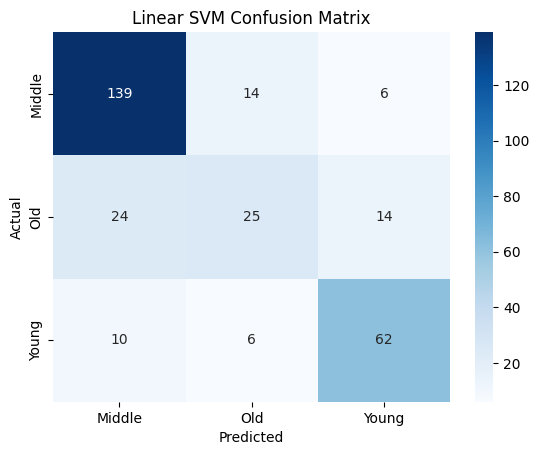

In [133]:
print(classification_report(y_test, y_pred_lin, target_names=age_labels))

lin_cm = confusion_matrix(y_test, y_pred_lin)

sns.heatmap(
    data=lin_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=age_labels,
    yticklabels=age_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Linear SVM Confusion Matrix")
plt.show()

## 4.2 Poly SVM

In [134]:
svm_poly_tuned_decision_scores = svm_poly_tuned.decision_function(X_test)
poly_conf_scores_df = pd.DataFrame(data=svm_poly_tuned_decision_scores, columns=binary_classifiers)

y_pred_poly = svm_poly_tuned.predict(X_test)
poly_conf_scores_df['Predicted'] = y_pred_poly
poly_conf_scores_df.head()


,Middle vs Old,Middle vs Young,Old vs Young,Predicted
0,0.725084,5.287622,3.878692,0
1,1.482990,3.543522,1.363723,0
2,0.719277,-0.045512,-0.278688,2
3,0.373225,1.947232,1.583799,0
4,0.836466,-0.486827,-0.688591,2


              precision    recall  f1-score   support

      Middle       0.74      0.91      0.81       159
         Old       0.00      0.00      0.00        63
       Young       0.58      0.77      0.66        78

    accuracy                           0.68       300
   macro avg       0.44      0.56      0.49       300
weighted avg       0.54      0.68      0.60       300



/home/elahe/Projects/py/pattern-recognition/.venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elahe/Projects/py/pattern-recognition/.venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elahe/Projects/py/pattern-recognition/.venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

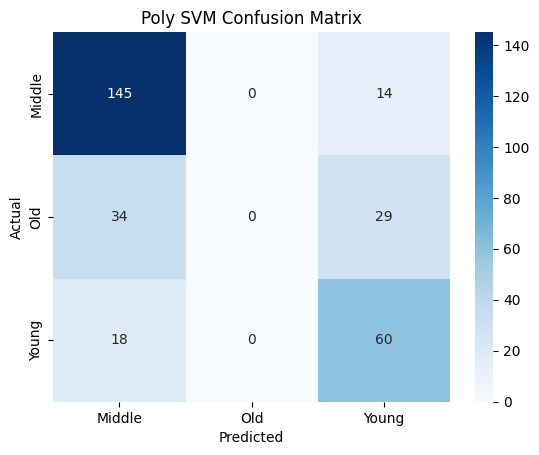

In [135]:
print(classification_report(y_test, y_pred_poly, target_names=age_labels))

poly_cm = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(
    data=poly_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=age_labels,
    yticklabels=age_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Poly SVM Confusion Matrix")
plt.show()

## 4.3 RBF SVM

In [136]:
svm_rbf_tuned_decision_scores = svm_rbf_tuned.decision_function(X_test)
rbf_conf_scores_df = pd.DataFrame(data=svm_rbf_tuned_decision_scores, columns=binary_classifiers)

y_pred_rbf = svm_rbf_tuned.predict(X_test)
rbf_conf_scores_df['Predicted'] = y_pred_rbf
rbf_conf_scores_df.head()


,Middle vs Old,Middle vs Young,Old vs Young,Predicted
0,0.410893,0.712816,0.456412,0
1,1.809258,1.596239,0.338257,0
2,0.143033,0.167629,-0.034746,0
3,0.395502,1.521782,1.144414,0
4,0.314894,-0.312847,-0.758849,2


              precision    recall  f1-score   support

      Middle       0.74      0.93      0.83       159
         Old       0.62      0.24      0.34        63
       Young       0.73      0.72      0.72        78

    accuracy                           0.73       300
   macro avg       0.70      0.63      0.63       300
weighted avg       0.71      0.73      0.70       300



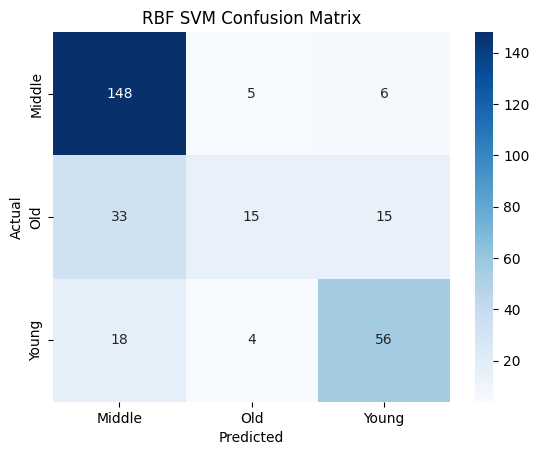

In [139]:
print(classification_report(y_test, y_pred_rbf, target_names=age_labels))

rbf_cm = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(
    data=rbf_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=age_labels,
    yticklabels=age_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RBF SVM Confusion Matrix")
plt.show()

# Stage 6: Observing standardization in effect

In [11]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def observe():
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.30, random_state=0
    )
    scalers = ['', StandardScaler(), MinMaxScaler()]
    scaler_names = ['', "StandardScaler", "MinMaxScaler"]
    scalable_features = ["Salary", "AmountSpent"]

    print(">>>> WITHOUT Scaling<<<<<")
    for i in range(3):
        if i > 0:
            X_train[scalable_features] = scalers[i].fit_transform(
                X_train[scalable_features]
            )
            X_test[scalable_features] = scalers[i].transform(
                X_test[scalable_features]
            )
            print(f">>>> With {scaler_names[i]} <<<<<")

        # linear kernel
        svm_lin = SVC(kernel="linear")
        svm_lin.fit(X_train, y_train)
        y_pred_lin = svm_lin.predict(X_test)
        print(f"Linear Kernel Accuracy: {accuracy_score(y_test, y_pred_lin):.1%}")

        print("------------------Poly------------------")
        poly_param_grid = {
            "C": [0.01, 0.1, 1],
            "degree": [2, 3, 4, 5, 7],
            "kernel": ["poly"],
            "decision_function_shape": ["ovo"],
        }
        grid_search_poly = GridSearchCV(
            SVC(), poly_param_grid, cv=5, return_train_score=True
        )
        grid_search_poly.fit(X_train, y_train)

        svm_poly_tuned = SVC(**grid_search_poly.best_params_)
        svm_poly_tuned.fit(X_train, y_train)
        y_pred_poly = svm_poly_tuned.predict(X_test)

        best_params_table = PrettyTable(["Best Parameters", "Best Training Score"])
        best_params_table.add_row(
            [grid_search_poly.best_params_, f"{grid_search_poly.best_score_:.2%}"]
        )
        print(best_params_table)
        print(classification_report(y_test, y_pred_poly, target_names=age_labels))

        print("------------------RBF------------------")
        rbf_param_grid = {
            "C": [0.01, 0.1, 1],
            "gamma": [0.01, 0.1, 1],
            "kernel": ["rbf"],
            "decision_function_shape": ["ovo"],
        }
        grid_search_rbf = GridSearchCV(
            SVC(), rbf_param_grid, cv=5, return_train_score=True
        )
        grid_search_rbf.fit(X_train, y_train)

        svm_rbf_tuned = SVC(**grid_search_rbf.best_params_)
        svm_rbf_tuned.fit(X_train, y_train)
        y_pred_rbf = svm_rbf_tuned.predict(X_test)

        best_params_table = PrettyTable(["Best Parameters", "Best Training Score"])
        best_params_table.add_row(
            [grid_search_rbf.best_params_, f"{grid_search_rbf.best_score_:.2%}"]
        )
        print(best_params_table)
        print(classification_report(y_test, y_pred_rbf, target_names=age_labels))


observe()

>>>> WITHOUT Scaling<<<<<
Linear Kernel Accuracy: 68.3%
------------------Poly------------------
+---------------------------------------------------------------------------+---------------------+
|                              Best Parameters                              | Best Training Score |
+---------------------------------------------------------------------------+---------------------+
| {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2, 'kernel': 'poly'} |        69.29%       |
+---------------------------------------------------------------------------+---------------------+
              precision    recall  f1-score   support

      Middle       0.73      0.94      0.82       159
         Old       0.00      0.00      0.00        63
       Young       0.62      0.77      0.69        78

    accuracy                           0.70       300
   macro avg       0.45      0.57      0.50       300
weighted avg       0.55      0.70      0.61       300

------------------RBF-